In [1]:
from hyperopt import fmin, tpe, hp
best = fmin(
    fn=lambda x: x,
    space=hp.uniform('x', 0, 1),
    algo=tpe.suggest,
    max_evals=100)
print best


{'x': 0.000269455723739237}


In [2]:
best = fmin(
    fn=lambda x: (x-1)**2,
    space=hp.uniform('x', -2, 2),
    algo=tpe.suggest,
    max_evals=100)
print best

{'x': 0.997369045274755}


In [3]:
from math import sin

best = fmin(
    fn=lambda x: -sin(x)/x,
    space=hp.uniform('x', -2, 2),
    algo=tpe.suggest,
    max_evals=100)
print best

{'x': 0.005699915437443186}


In [4]:
import hyperopt.pyll.stochastic

space = {
    'x': hp.uniform('x', 0, 1),
    'y': hp.normal('y', 0, 1),
    'name': hp.choice('name', ['alice', 'bob']),
}

print hyperopt.pyll.stochastic.sample(space)
print hyperopt.pyll.stochastic.sample(space)
print hyperopt.pyll.stochastic.sample(space)
print hyperopt.pyll.stochastic.sample(space)

{'y': 0.23609944644398817, 'x': 0.9430744862477005, 'name': 'bob'}
{'y': -1.2256144190334712, 'x': 0.9338207439035885, 'name': 'alice'}
{'y': 0.1453309716946144, 'x': 0.27128267495632974, 'name': 'alice'}
{'y': 0.8706492900739177, 'x': 0.37847610773946727, 'name': 'alice'}


In [5]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

fspace = {
    'x': hp.uniform('x', -5, 5)
}

def f(params):
    x = params['x']
    val = x**2
    return {'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=1000, trials=trials)

print 'best:', best

print 'trials:'
for trial in trials.trials[:2]:
    print trial

best: {'x': 0.001234411972705929}
trials:
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 0, 'idxs': {'x': [0]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'x': [1.9646918559786162]}, 'workdir': None}, 'state': 2, 'tid': 0, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': 3.8600140889486996}, 'owner': None, 'spec': None}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 1, 'idxs': {'x': [1]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'x': [-3.9393509404526728]}, 'workdir': None}, 'state': 2, 'tid': 1, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': 15.518485832045357}, 'owner': None, 'spec': None}


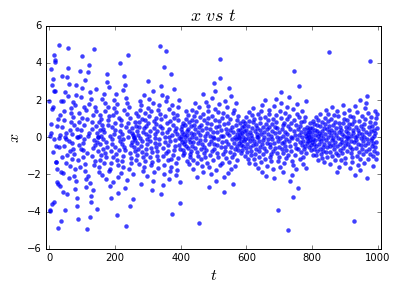

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['x'] for t in trials.trials]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$x$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16)

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
  species   measurement  value
0  setosa  sepal_length    5.1
1  setosa  sepal_length    4.9
2  setosa  sepal_length    4.7
3  setosa  sepal_length    4.6
4  setosa  sepal_length    5.0


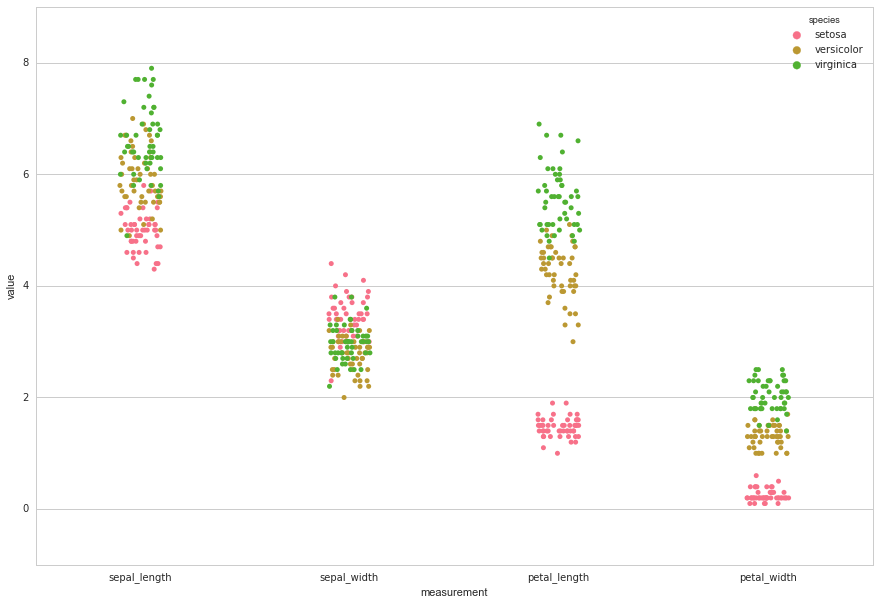

In [8]:
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", palette="husl")

iris = sns.load_dataset("iris")
print iris.head()

iris = pd.melt(iris, "species", var_name="measurement")
print iris.head()

f, ax = plt.subplots(1, figsize=(15,10))
sns.stripplot(x="measurement", y="value", hue="species", data=iris, jitter=True, edgecolor="white", ax=ax)

In [9]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,100))
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best
print hyperopt_train_test(best)

best:
{'n_neighbors': 4}
0.973447712418


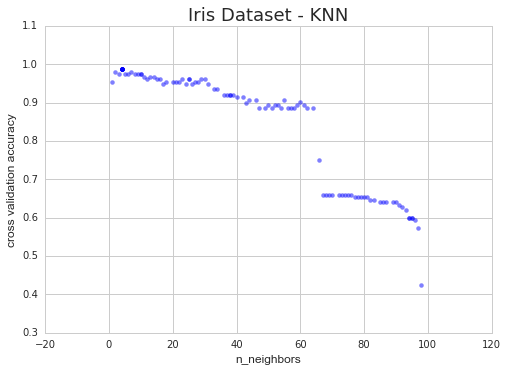

In [10]:
f, ax = plt.subplots(1) #, figsize=(10,10))
xs = [t['misc']['vals']['n_neighbors'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('Iris Dataset - KNN', fontsize=18)
ax.set_xlabel('n_neighbors', fontsize=12)
ax.set_ylabel('cross validation accuracy', fontsize=12)

In [11]:
# now with scaling as an option
from sklearn import datasets
from sklearn.preprocessing import normalize, scale
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    X_ = X[:]

    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']

    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X_, y).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,50)),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best
print hyperopt_train_test(best)


best:
{'normalize': 0, 'n_neighbors': 4, 'scale': 0}
0.973447712418


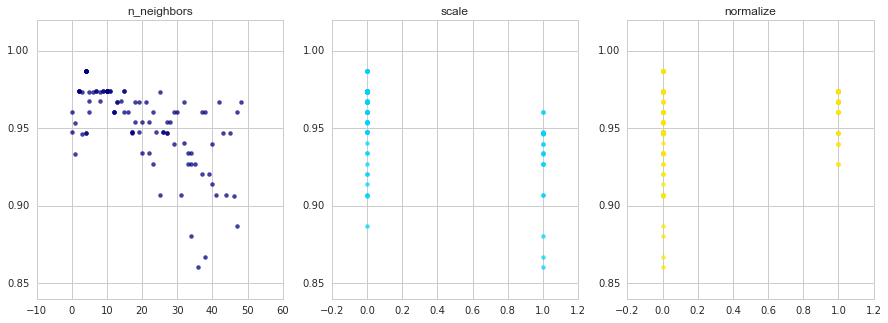

In [12]:
import numpy as np

parameters = ['n_neighbors', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=cmap(float(i)/len(parameters)))

    axes[i].set_title(val)

best:
{'normalize': 0, 'kernel': 0, 'C': 11.650371051027797, 'scale': 1, 'gamma': 2.7011247557444684}
0.97385620915


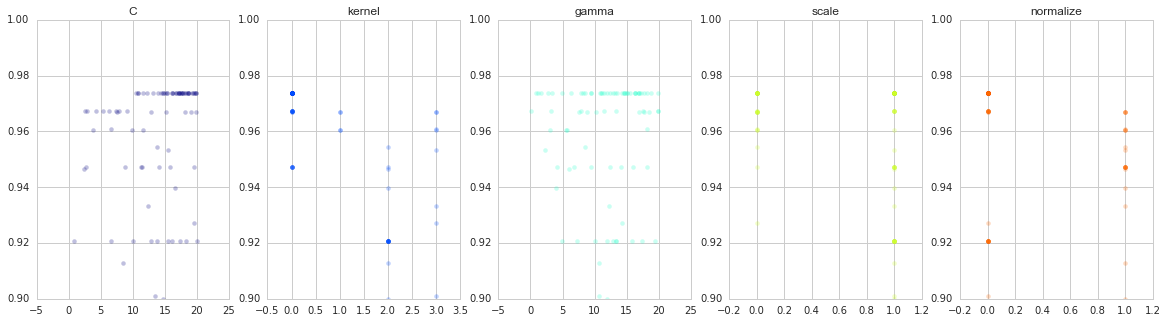

In [13]:
from sklearn.svm import SVC

iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    X_ = X[:]

    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']

    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']

    clf = SVC(**params)
    return cross_val_score(clf, X_, y).mean()

kernels = ['linear', 'sigmoid', 'poly', 'rbf']

space4svm = {
    'C': hp.uniform('C', 0, 20),
    'kernel': hp.choice('kernel', kernels),
    'gamma': hp.uniform('gamma', 0, 20),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4svm, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best
best['kernel'] = kernels[best['kernel']]
print hyperopt_train_test(best)

parameters = ['C', 'kernel', 'gamma', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.25, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    axes[i].set_ylim([0.9, 1.0])

In [14]:
from sklearn.tree import DecisionTreeClassifier

iris = datasets.load_iris()
X_original = iris.data
y_original = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']

    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X, y).mean()

criterions = ["gini", "entropy"]

space4dt = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'criterion': hp.choice('criterion', criterions),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)
best['criterion'] = criterions[best['criterion']]
print 'best:'
print best
print hyperopt_train_test(best)

best:
{'max_features': 1, 'normalize': 1, 'scale': 0, 'criterion': 'gini', 'max_depth': 5}
0.926470588235


In [19]:
from sklearn.naive_bayes import BernoulliNB

digits = datasets.load_digits()
X = digits.data
y = digits.target
print X.shape, y.shape

def hyperopt_train_test(params):
    t = params['type']
    del params['type']
    if t == 'naive_bayes':
        clf = BernoulliNB(**params)
    elif t == 'svm':
        clf = SVC(**params)
    elif t == 'dtree':
        clf = DecisionTreeClassifier(**params)
    elif t == 'knn':
        clf = KNeighborsClassifier(**params)
    else:
        return 0
    return cross_val_score(clf, X, y, cv=5, scoring="accuracy").mean()

space = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
        'alpha': hp.uniform('alpha', 0.0, 2.0)
    },
    {
        'type': 'svm',
        'C': hp.uniform('C', 0, 10.0),
        'kernel': hp.choice('kernel', ['linear', 'rbf']),
        'gamma': hp.uniform('gamma', 0, 20.0)
    },
    {
        'type': 'randomforest',
        'max_depth': hp.choice('max_depth', range(1,20)),
        'max_features': hp.choice('max_features', range(1,5)),
        'n_estimators': hp.choice('n_estimators', range(1,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'scale': hp.choice('scale', [0, 1]),
        'normalize': hp.choice('normalize', [0, 1])
    },
    {
        'type': 'knn',
        'n_neighbors': hp.choice('knn_n_neighbors', range(1,50))
    }
])

space = hp.choice('classifier_type', [
    {
        'type': 'svm',
        'C': hp.uniform('C', 0, 10.0),
        'kernel': hp.choice('kernel', ['linear', 'rbf']),
        'gamma': hp.uniform('gamma', 0, 20.0)
    },

count = 0
best = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params.copy())
    if acc > best:
        print 'new best:', acc, 'using', params['type']
        best = acc
    if count % 50 == 0:
        print 'iters:', count, ', acc:', acc, 'using', params
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=200, trials=trials)
print 'best:'
print best


(1797L, 64L) (1797L,)
new best: 0.120775734196 using svm
new best: 0.949334872621 using svm
new best: 0.9666281215 using knn
iters: 50 , acc: 0.931034143128 using {'n_neighbors': 46, 'type': 'knn'}
iters: 100 , acc: 0.954450921403 using {'n_neighbors': 16, 'type': 'knn'}
iters: 150 , acc: 0.941059867997 using {'n_neighbors': 33, 'type': 'knn'}
iters: 200 , acc: 0.931034143128 using {'n_neighbors': 40, 'type': 'knn'}
best:
{'knn_n_neighbors': 1, 'classifier_type': 3}
